CASA0013 Introduction to Programming\
SID:20081860\
Exploring the Impacts of Airbnb on Tourism\
Word count for the Executive Briefing: 2412

# I. Reproducible Analysis

I'll produce maps and do a little bit of NLP on the topics people mentioned in the description

In [1]:
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import OneHotEncoder # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
import spacy
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.tokenize.stanford import StanfordTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
df = pd.read_csv("listings.csv")
df.shape

(76984, 74)

In [4]:
df.columns.values

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'calen

In [5]:
cols = ['id', 'listing_url', 'name',
       'description', 'neighborhood_overview', 'host_id',
       'host_since', 'host_location',
       'host_about', 'host_is_superhost', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'calendar_updated', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'calendar_last_scraped']

In [6]:
df2 = df[['id', 'listing_url', 'name',
       'description', 'neighborhood_overview', 'host_id',
       'host_since', 'host_location',
       'host_about', 'host_is_superhost', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights']]

Formatting and erasing lines that are off boundaries, it's also worth noting low effort listings should be removed too because they add little to the study without proper description even if their location is fantastic, there is no occupancy rate data available to see if these 'low effort' listings actually got any guests, so it's better to get rid of them now

In [7]:
#routine stuff, drop NAs and just useless stuff
df2['price'] = df2.price.str.replace('$','').str.replace(',','').astype(float)
df2.drop(df2[((df2.latitude.isna())|(df2.longitude.isna()))].index, axis=0, inplace=True)
df2.drop(df2[((df2.latitude < 40)|(df2.longitude > 1))].index, axis=0, inplace=True)
df2.drop(index=(df2[(df2.description.isna()) | (df2.amenities.isna()) | (df2.host_about.isna())].index), inplace=True)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/envs/sds2020/lib/python3.7/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/envs/sds2020/lib/python3.7/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [8]:
df2.shape

(41835, 30)

In [9]:
total_listings=df2.shape[0]

#### ok, so we have 41835 listings in London
Slimmed down from 77000 listings to about 42000 left because those without proper descriptions should be considered invalid and low effort

### Getting msoa codes for the listings
The information about MSOA is needed for grouping later

In [10]:
gpd_df2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude, df2.latitude,crs='epsg:4326'))
gpd_df2 = gpd_df2.to_crs('epsg:27700')

In [11]:
gpd_df2.shape

(41835, 31)

<AxesSubplot:>

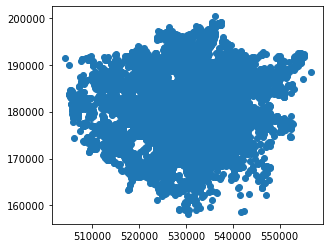

In [12]:
gpd_df2.plot()

In [13]:
gpd_df2.columns.values

array(['id', 'listing_url', 'name', 'description',
       'neighborhood_overview', 'host_id', 'host_since', 'host_location',
       'host_about', 'host_is_superhost', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights', 'geometry'],
      dtype=object)

In [14]:

#col1=['id', 'listing_url', 'name', 'description',
#       'neighborhood_overview', 'host_id', 'host_since', 'host_location',
#       'host_about', 'host_is_superhost', 'neighbourhood',
#       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
#       'latitude', 'longitude', 'property_type', 'room_type',
#       'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
#       'amenities', 'price', 'minimum_nights', 'maximum_nights',
#       'minimum_minimum_nights', 'maximum_minimum_nights',
#       'minimum_maximum_nights', 'maximum_maximum_nights', 'list_geometry']

#gpd_df2.columns=col1

In [15]:
#gpd_df2 is for subsetting use, need to get a copy of gpd_df2 for plotting use
pd.options.display.max_colwidth=20
gpd_df3 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude, df2.latitude,crs='epsg:4326'))
gpd_df3 = gpd_df3.to_crs('epsg:27700')

In [16]:
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')

In [17]:
boros.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [18]:
msoas=gpd.read_file("geo/London_MSOAs.gpkg")

In [19]:
msoas.sample(3)

,OBJECTID,MSOA11CD,MSOA11NM,BNG_E,BNG_N,Borough,msoa11hclnm,geometry
438,439,E02000456,Harrow 024,514310,188009,Harrow,West Harrow,POLYGON ((514986...
6,7,E02000008,Barking and Dage...,548218,185920,Barking and Dage...,Becontree East,POLYGON ((548171...
978,6784,E02006927,Greenwich 034,540765,175168,Greenwich,Kidbrooke South,POLYGON ((541029...


In [20]:
gdf_msoa = gpd.sjoin(gpd_df2, msoas, op='within')

In [21]:
gdf_msoa.columns.values

array(['id', 'listing_url', 'name', 'description',
       'neighborhood_overview', 'host_id', 'host_since', 'host_location',
       'host_about', 'host_is_superhost', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights', 'geometry',
       'index_right', 'OBJECTID', 'MSOA11CD', 'MSOA11NM', 'BNG_E',
       'BNG_N', 'Borough', 'msoa11hclnm'], dtype=object)

In [22]:
gdf_msoa.sample(3)

,id,listing_url,name,description,neighborhood_overview,host_id,host_since,host_location,host_about,host_is_superhost,...,maximum_maximum_nights,geometry,index_right,OBJECTID,MSOA11CD,MSOA11NM,BNG_E,BNG_N,Borough,msoa11hclnm
19561,15316996,https://www.airb...,The Book Room,The book room is...,"This is a quiet,...",10561005,2013-12-11,London,"I am an artist, ...",f,...,90,POINT (523899.22...,104,105,E02000107,Brent 015,523359,185520,Brent,Cricklewood Anso...
68570,42597637,https://www.airb...,Bed in 4-Bed Mix...,Located in the m...,You'll find us i...,175828841,2018-02-28,"London, England,...",Winner of No.1 S...,f,...,365,POINT (526418.26...,565,566,E02000586,Kensington and C...,526035,179310,Kensington and C...,Queen's Gate
43163,28810023,https://www.airb...,Room in cute fla...,A bedroom in a m...,The neighbourhoo...,23096557,2014-10-29,"London, United K...",Seeing new count...,f,...,1125,POINT (532790.79...,544,545,E02000565,Islington 012,533041,185225,Islington,Newington Green


In [23]:
gdf_msoa.drop(columns=['host_since', 'host_location','host_is_superhost', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed','index_right','minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights', 'index_right', 'OBJECTID', 'BNG_E', 'BNG_N'],inplace=True)

In [24]:
gdf_msoa.sample(3)

,id,listing_url,name,description,neighborhood_overview,host_id,host_about,latitude,longitude,property_type,...,bathrooms_text,bedrooms,beds,amenities,price,geometry,MSOA11CD,MSOA11NM,Borough,msoa11hclnm
12204,9935994,https://www.airb...,2 Bed/2 Bath Apa...,Stunning and bri...,The area is nota...,2074840,We are a profess...,51.51837,-0.12220,Entire apartment,...,2 baths,2.0,2.0,"[""Cable TV"", ""Be...",159.0,POINT (530386.05...,E02000193,Camden 028,Camden,"Holborn, St Gile..."
35444,23767492,https://www.airb...,Victorian Hackne...,The apartment is...,If you stayed he...,8591715,Hi!\r\n\r\nMy na...,51.55810,-0.06608,Entire apartment,...,2 baths,2.0,2.0,"[""TV"", ""Heating""...",99.0,POINT (534162.76...,E02000354,Hackney 010,Hackney,Hackney Downs
60483,39043863,https://www.airb...,Thrive Apartment...,** COVID19 UPDAT...,Main attractions...,126482513,"My name is Alex,...",51.46014,-0.16672,Entire condominium,...,1 bath,2.0,2.0,"[""Dryer"", ""Priva...",123.0,POINT (527459.47...,E02000930,Wandsworth 008,Wandsworth,Lavender Hill We...


<AxesSubplot:>

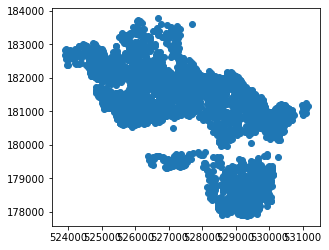

In [25]:
gdf_msoa[gdf_msoa.Borough=='Westminster'].plot()

Lets take a look at the amount of listings per borough

In [26]:
all_count=gdf_msoa.groupby(['Borough']).agg(
    {'name':['count']}
).reset_index()
all_count.columns = all_count.columns.droplevel(0)
cols = all_count.columns.values
cols[0]  = 'Borough'
cols[1]  = 'Count'
all_count.columns = cols

In [27]:
all_count.sort_values(by='Count', ascending=False)

,Borough,Count
32,Westminster,4838
11,Hackney,3440
29,Tower Hamlets,3434
19,Kensington and C...,3075
5,Camden,3038
18,Islington,2577
21,Lambeth,2468
27,Southwark,2442
31,Wandsworth,2050
12,Hammersmith and ...,2048


In [28]:
#yo give me back msoa's geometry
#gdf_msoa_c=gdf_msoa.merge(msoas,how="right",on="MSOA11CD")
#gdf_msoa_c.drop(columns=['OBJECTID' ,'MSOA11NM_y','BNG_E', 'BNG_N', 'Borough_y','msoa11hclnm_y'])

### Mapping, and filtering listings 500m around tourist spots
Chose 500m because it is worth seeing if living right next to a attraction is more desirable, and 1k perimeter included way too much listings in

In [29]:
#rip try reading geoson
tspot = gpd.read_file("tourist_attraction_GJ.geojson")
tspot = tspot.to_crs("epsg:27700")

In [30]:
tspot.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [31]:
tspot.columns.values

array(['id', '@id', 'building', 'name', 'operator', 'tourism', 'type',
       'website', 'wikidata', 'wikipedia', 'castle_type', 'historic',
       'name:es', 'name:zh', 'wheelchair', 'addr:city', 'addr:country',
       'addr:housenumber', 'addr:postcode', 'addr:street', 'alt_name',
       'building:levels', 'building:material', 'contact:phone',
       'contact:website', 'email', 'fax', 'heritage', 'name:de',
       'name:el', 'name:en', 'name:he', 'name:ru', 'office',
       'official_name', 'phone', 'roof:colour', 'roof:levels',
       'addr:housename', 'name:et', 'name:fr', 'name:lv', 'opening_hours',
       'toilets', 'toilets:access', 'toilets:female', 'toilets:male',
       'amenity', 'height', 'name:pl', 'roof:height', 'roof:shape',
       'addr:suburb', 'building:colour', 'building:part', 'government',
       'layer', 'name:af', 'name:cy', 'name:ga', 'name:gl', 'name:it',
       'name:ja', 'name:kn', 'name:pt', 'name:ro', 'name:sco', 'name:sk',
       'name:sr', 'name:th', 'nam

In [32]:
tspot['name'].head(5)

0         The Royal Mews
1    Saint James's Pa...
2        Bank of England
3      Kensington Palace
4    Shakespeare's Globe
Name: name, dtype: object

In [33]:
# time to slim tspot a bit for merging the msoa data in
tspot1 = tspot[['name', 'geometry']]

In [34]:
#try sjoining and get the msoa
tspot_msoa = gpd.sjoin(msoas,tspot1)

In [35]:
tspot_msoa.Borough.unique()

array(['City of London', 'Southwark', 'Camden', 'Barnet', 'Brent',
       'Hackney', 'Hammersmith and Fulham', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Lambeth', 'Newham',
       'Richmond upon Thames', 'Tower Hamlets', 'Waltham Forest',
       'Wandsworth', 'Westminster', 'Lewisham', 'Greenwich'], dtype=object)

In [36]:
tspot_msoa.sample(2, random_state=42)

,OBJECTID,MSOA11CD,MSOA11NM,BNG_E,BNG_N,Borough,msoa11hclnm,geometry,index_right,name
0,1,E02000001,City of London 001,532384,181355,City of London,City of London,POLYGON ((532135...,274,City Visitor Trail
946,947,E02000979,Westminster 020,529779,179631,Westminster,Central Westminster,POLYGON ((530378...,90,Big Ben


In [37]:
#tspot_msoa is no good because it made my tourist spot into tourist MSOA!!! I only need borough data, plz dont mess with my geometry
t_boro=pd.merge(tspot_msoa[["name",'Borough']], tspot1,left_on='name',right_on='name', how='right')

In [38]:
t_boro.head(2)

,name,Borough,geometry
0,The Royal Mews,Westminster,POLYGON ((528876...
1,Saint James's Pa...,Westminster,POLYGON ((529288...


In [39]:
#t_boro is a dataframe, not GeoDataFrame, gotta point the geometry so we can plot later
t_boro = gpd.GeoDataFrame(t_boro,geometry=t_boro['geometry'],crs="EPSG:27700")

In [40]:
t_boro.head(1)

,name,Borough,geometry
0,The Royal Mews,Westminster,POLYGON ((528876...


Lets see the distrubution of tourist spots in each borough

In [41]:
t_count=t_boro.groupby(['Borough']).agg(
    {'name':['count']}
).reset_index()
t_count.columns = t_count.columns.droplevel(0)
cols = t_count.columns.values
cols[0]  = 'Borough'
cols[1]  = 'Count'
t_count.columns = cols

In [42]:
t_count.sort_values(by='Count', ascending=False)

,Borough,Count
18,Westminster,111
2,Camden,23
3,City of London,20
10,Lambeth,19
14,Southwark,19
9,Kensington and C...,19
15,Tower Hamlets,15
4,Greenwich,14
7,Hounslow,13
12,Newham,8


So Westminster got the most tourist spots, so this boro should probably be thriving off tourism dollars pretty well, compared to Islington, I'll pick Westminster and Islington and compare the impact of tourism on these 2 boros

In [43]:
#try sjoining and get the msoa
#westminster first
t_westminster = gpd.sjoin(t_boro[t_boro.Borough=="Westminster"],boros[boros.NAME=="Westminster"],op='within')

<AxesSubplot:>

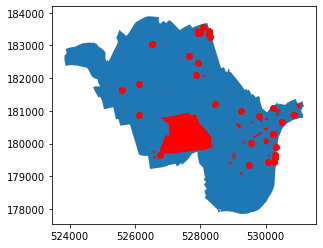

In [44]:
ax=boros[boros.NAME=="Westminster"].plot()
t_westminster.plot(ax=ax,color='red')

In [45]:
#then Islingotn
t_isl = gpd.sjoin(t_boro[t_boro.Borough=="Islington"],boros[boros.NAME=="Islington"],op='within')

<AxesSubplot:>

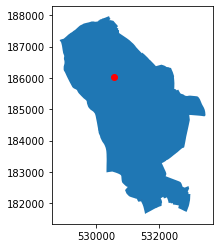

In [46]:
ax=boros[boros.NAME=="Islington"].plot()
t_isl.plot(ax=ax,color='red')

In [47]:
#sosad xd
t_isl

,name,Borough,geometry,index_right,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER
108,Clerk's Well,Islington,POLYGON ((531449...,27,Islington,E09000019,1485.664,0.0,T
610,Nags Head Market,Islington,POINT (530555.81...,27,Islington,E09000019,1485.664,0.0,T


### We'll get the listings 500m around a tourist attraction using the buffer method

In [48]:
#try buffering tspot
tspot_b = tspot.buffer(1000)

In [49]:
tspot_c = tspot.buffer(500)

<AxesSubplot:>

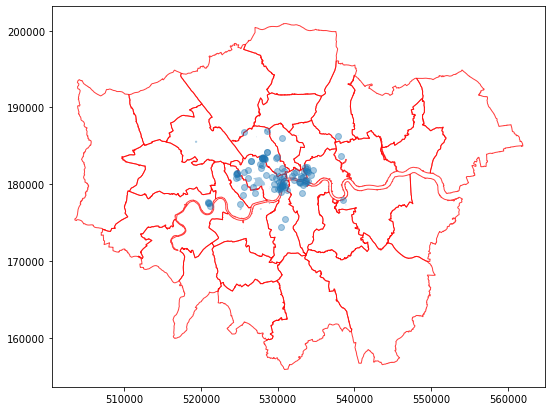

In [50]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
tspot.plot(ax=ax, alpha=0.4)


<AxesSubplot:>

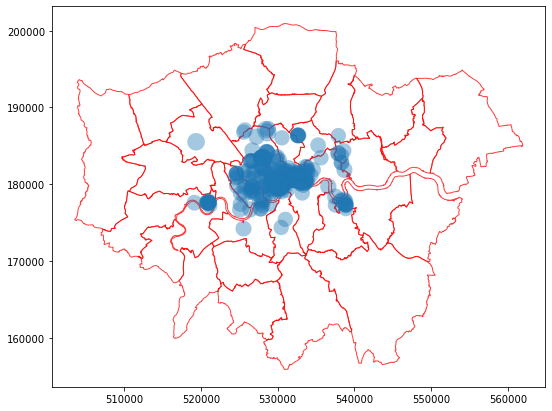

In [51]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
tspot_b.plot(ax=ax, alpha=0.4)


<AxesSubplot:>

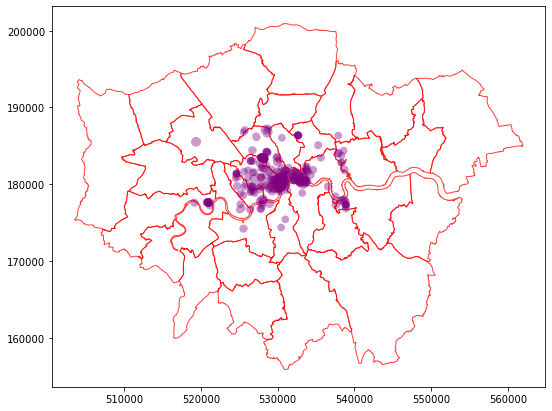

In [52]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
tspot_c.plot(ax=ax, alpha=0.4,color='purple')


In [53]:
tspot_c.shape

(276,)

In [54]:
nte_2017=gpd.read_file("geo_nighttime_workplace_2017.gpkg")

In [55]:
tspot_b_gpd = gpd.GeoDataFrame(geometry=gpd.GeoSeries(tspot_b))

<AxesSubplot:>

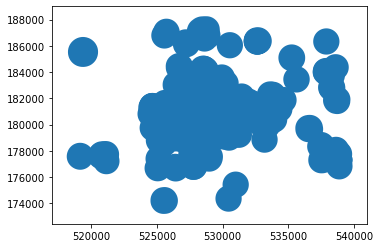

In [56]:
tspot_b_gpd.plot()

In [57]:
#try sjoining the bnb listings??????
bnb_t = gpd.sjoin(gpd_df2,tspot_b_gpd,op='within')

In [58]:
bnb_t.drop(columns=['listing_url','index_right','minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights','host_since','host_is_superhost','amenities','neighbourhood_group_cleansed'], inplace=True)

In [59]:
bnb_t.shape
#well ripgg, theres more items than we had in the listings csv, sth's very wrong

(147137, 20)

<AxesSubplot:>

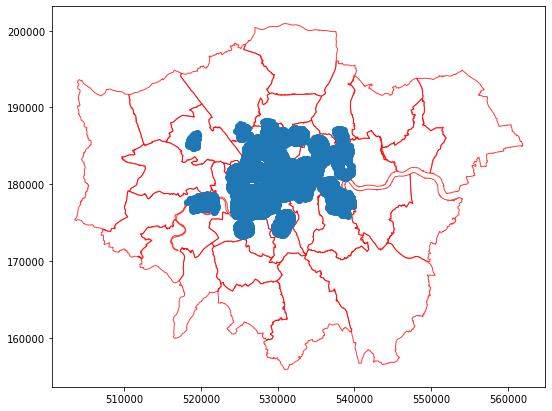

In [60]:
ax=boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
bnb_t.plot(ax=ax)


In [61]:
#sth's probably off because of the overlapping dots on the map
bnb_t.id.value_counts()

45099583    59
20584587    58
12421194    58
24931906    57
1749852     57
            ..
29535245     1
29350365     1
567534       1
3513323      1
25804856     1
Name: id, Length: 21773, dtype: int64

In [62]:
bnb_t = bnb_t.drop_duplicates(subset=['id'])

In [63]:
bnb_t.shape

(21773, 20)

## Compare with the 500m buffer

In [64]:
tspot_c_gpd = gpd.GeoDataFrame(geometry=gpd.GeoSeries(tspot_c))

In [65]:
#try sjoining the bnb listings??????
bnb_500 = gpd.sjoin(gdf_msoa,tspot_c_gpd,op='within')

In [66]:
bnb_500.columns.values

array(['id', 'listing_url', 'name', 'description',
       'neighborhood_overview', 'host_id', 'host_about', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities',
       'price', 'geometry', 'MSOA11CD', 'MSOA11NM', 'Borough',
       'msoa11hclnm', 'index_right'], dtype=object)

In [67]:
bnb_500['Borough']=bnb_500.MSOA11NM.str.replace(r' \d+$','',regex=True)

In [68]:
bnb_500.drop(columns=['listing_url', 'amenities'], inplace=True)

In [69]:
bnb_500.shape

(33819, 22)

In [70]:
bnb_500 = bnb_500.drop_duplicates(subset=['id'])

In [71]:
bnb_500.shape

(11979, 22)

In [72]:
print(f"There are {bnb_t.shape[0]} listings in a 1km circle from tourist spots, that's {100*bnb_t.shape[0]/total_listings:0.2f}% of all valid listings")
print(f"There are {bnb_500.shape[0]} listings in a 500m circle from tourist spots, that's {100*bnb_500.shape[0]/total_listings:0.2f}% of all valid listings")

There are 21773 listings in a 1km circle from tourist spots, that's 52.04% of all valid listings
There are 11979 listings in a 500m circle from tourist spots, that's 28.63% of all valid listings


500m circle is more reliable, I marked the 11979 listings as listings aimed at tourists

In [73]:
#get the number of listings in a MSOA and their median prices, median becuz it's not easily affected by extreme numbers
p_1k = bnb_500.groupby(['Borough','MSOA11CD']).agg(
    {'id':['count'],'price':['median']}
).reset_index()

In [74]:
p_1k.columns.values

array([('Borough', ''), ('MSOA11CD', ''), ('id', 'count'),
       ('price', 'median')], dtype=object)

In [75]:
p_1k.columns = p_1k.columns.droplevel(0)
cols = p_1k.columns.values
cols[0]  = 'Borough'
cols[1]  = 'MSOA'
p_1k.columns = cols

In [76]:
p_1k.sort_values(by='count', ascending=False).head(20)

,Borough,MSOA,count,median
172,Westminster,E02000972,586,150.0
177,Westminster,E02000977,585,150.0
28,Camden,E02000193,349,130.0
176,Westminster,E02000976,324,93.5
138,Tower Hamlets,E02000878,311,81.0
29,City of London,E02000001,308,107.5
175,Westminster,E02000975,304,100.0
170,Westminster,E02000970,298,153.5
89,Kensington and C...,E02000589,280,135.0
141,Tower Hamlets,E02000884,267,81.0


In [77]:
p_1k=pd.merge(p_1k, msoas[["MSOA11CD",'geometry']],left_on='MSOA',right_on='MSOA11CD', how='right')

In [78]:
p_1k=p_1k[p_1k.MSOA.notna()]

In [79]:
p_1k.sample(2)

,Borough,MSOA,count,median,MSOA11CD,geometry
569,Kensington and C...,E02000590,153.0,135.0,E02000590,POLYGON ((526865...
982,Greenwich,E02006931,48.0,75.5,E02006931,POLYGON ((538824...


Text(0.5, 1.0, 'Number of listings 500m from marked tourist spots by MSOA level')

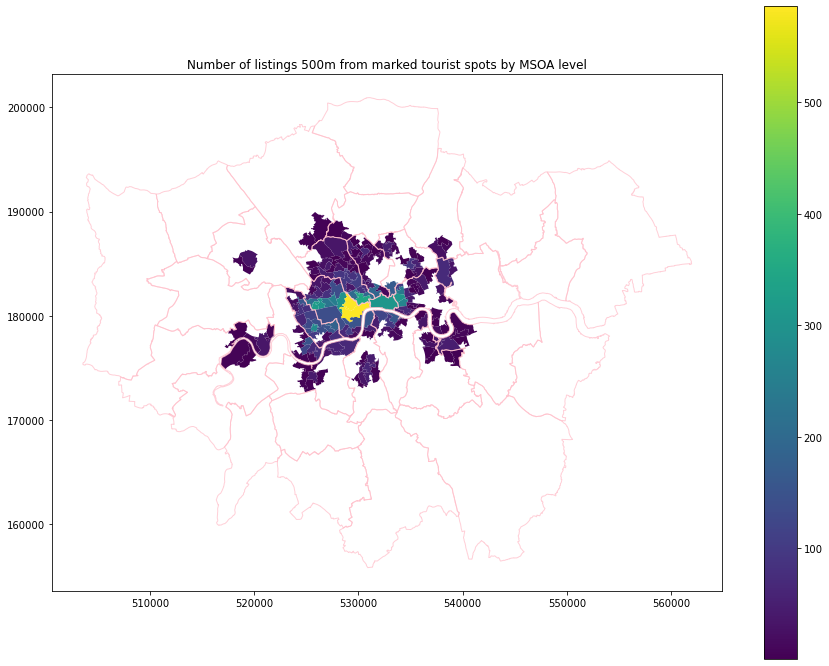

In [80]:
p_1k = p_1k.set_geometry('geometry')
ax = p_1k.plot(figsize=(15,12),column='count', legend=True);
boros.plot(edgecolor='pink', facecolor='none', linewidth=1, alpha=0.75,ax=ax)
#tspot.plot(ax=ax, color='white')
ax.set_title("Number of listings 500m from marked tourist spots by MSOA level")


I want to compare Westminster and Islington seperately, so let's subset the area out and dig deeper into MSOA level

In [81]:
#subset westminster out
w_tspot=p_1k[p_1k.Borough=="Westminster"]

<AxesSubplot:>

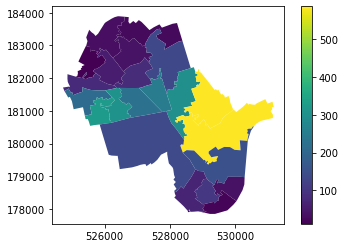

In [82]:
w_tspot.plot(column='count',legend=True)

<AxesSubplot:>

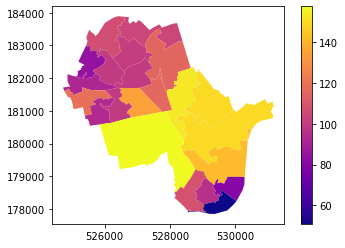

In [83]:
w_tspot.plot(column='median',cmap='plasma',legend=True)

In [84]:
west_all = gdf_msoa.groupby(['Borough','MSOA11CD']).agg(
    {'id':['count'],'price':['median']}
).reset_index()

In [85]:
west_all=west_all[west_all.Borough=="Westminster"]

In [86]:
west_all.columns = west_all.columns.droplevel(0)
cols = west_all.columns.values
cols[0]  = 'Borough'
cols[1]  = 'MSOA'
west_all.columns = cols

In [87]:
west_all=pd.merge(west_all, msoas[["MSOA11CD",'geometry']],left_on='MSOA',right_on='MSOA11CD', how='right')
west_all = west_all.set_geometry('geometry')

In [88]:
w = bnb_500[bnb_500['Borough']=="Westminster"].id.count()

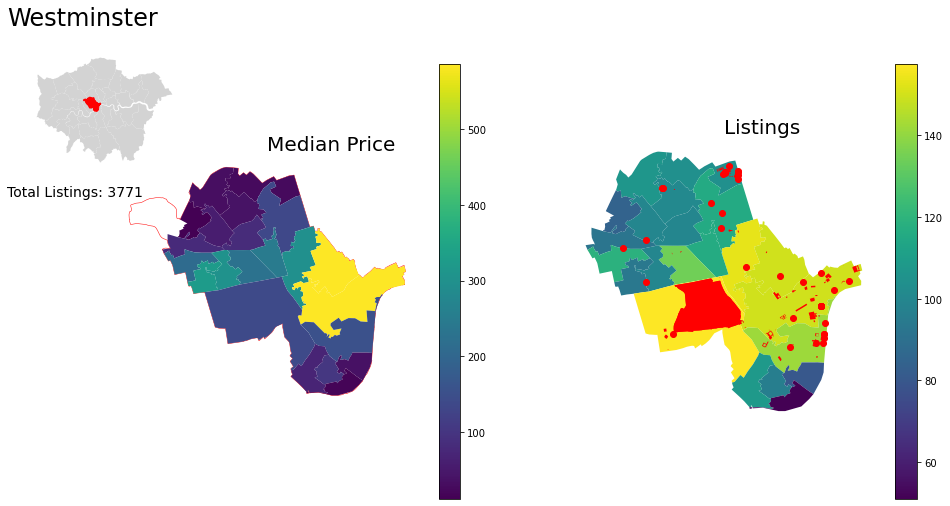

In [89]:
tfont = {'fontname':'DejaVu Sans', 'horizontalalignment':'left'}
f,axes = plt.subplots(1,2,figsize=(15,8))

boros[boros.NAME=="Westminster"].plot(ax=axes[0],edgecolor='red', facecolor='none',linewidth=0.5)
w_tspot.plot(column='count', ax=axes[0], legend=True, cmap='viridis')
w_tspot.copy().plot(column='median', ax=axes[1], legend=True, cmap='viridis')
t_westminster.plot(ax=axes[1],color='red')
for ax in axes:
    ax.axis('off')
    
    
ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
boros[boros.NAME=="Westminster"].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2)
ax2.axis('off')

f.suptitle("Westminster", x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Median Price', size=20, **tfont)
axes[1].set_title('Listings', size=20, **tfont)

plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {w}", size=14, **tfont);

#plt.savefig('west.png')

In [90]:
w_all=gdf_msoa[gdf_msoa['Borough']=="Westminster"].id.count()

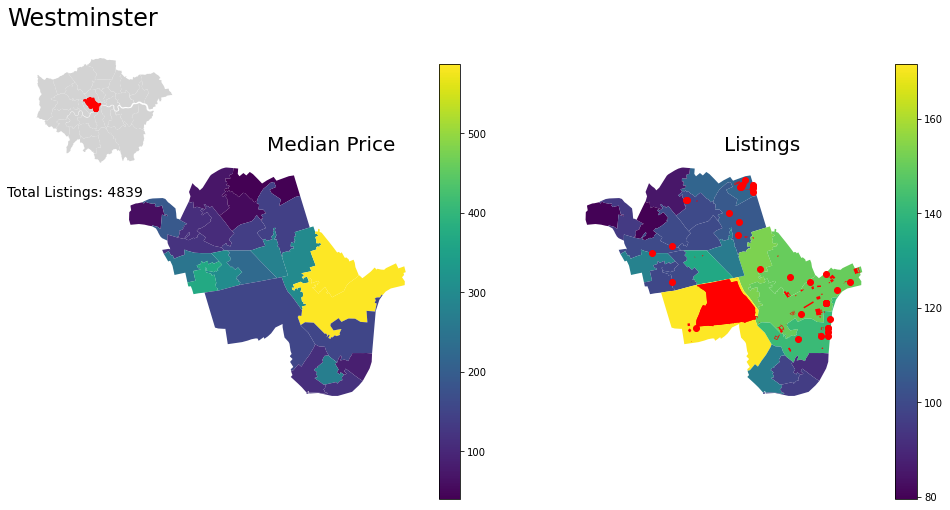

In [91]:
tfont = {'fontname':'DejaVu Sans', 'horizontalalignment':'left'}
f,axes = plt.subplots(1,2,figsize=(15,8))

west_all.plot(column='count', ax=axes[0], legend=True, cmap='viridis')
west_all.copy().plot(column='median', ax=axes[1], legend=True, cmap='viridis')
t_westminster.plot(ax=axes[1],color='red')
for ax in axes:
    ax.axis('off')
    
    
ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
boros[boros.NAME=="Westminster"].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2)
ax2.axis('off')

f.suptitle("Westminster", x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Median Price', size=20, **tfont)
axes[1].set_title('Listings', size=20, **tfont)

plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {w_all}", size=14, **tfont);

#plt.savefig('west.png')

So every pic is worth 250 words i better put 4 graphs into 1 to compare the effects of having tourist attractions

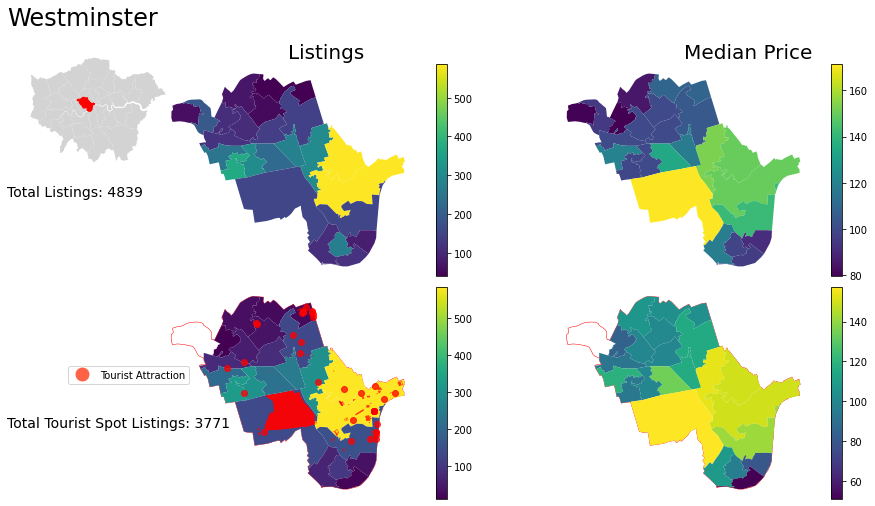

In [92]:
#GRID QUAD
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
tfont = {'fontname':'DejaVu Sans', 'horizontalalignment':'left'}
f_west,axes = plt.subplots(2,2,figsize=(14,8))
plt.subplots_adjust(wspace=0.025, hspace=0.05)

west_all.plot(column='count', ax=axes[0,0], legend=True, cmap='viridis')
west_all.copy().plot(column='median', ax=axes[0,1], legend=True, cmap='viridis')

boros[boros.NAME=="Westminster"].plot(ax=axes[1,1],edgecolor='red', facecolor='none',linewidth=0.5)
boros[boros.NAME=="Westminster"].plot(ax=axes[1,0],edgecolor='red', facecolor='none',linewidth=0.5)
w_tspot.plot(column='count', ax=axes[1,0], legend=True, cmap='viridis')
w_tspot.copy().plot(column='median', ax=axes[1,1], legend=True, cmap='viridis')
t_westminster.plot(ax=axes[1,0],color='red',alpha=0.75)
#cute mini map    
ax2 = f_west.add_axes([0.015, 0.7, 0.2, 0.2])
boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
boros[boros.NAME=="Westminster"].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2)
ax2.axis('off')

f_west.suptitle("Westminster", x=0.025, ha='left', size=24, **tfont)
axes[0,1].set_title('Median Price', size=20, **tfont)
axes[0,0].set_title('Listings', size=20, **tfont)



for ax in axes.flat:
    ax.label_outer()
    ax.axis('off')
    
plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {w_all}", size=14, **tfont);   
plt.figtext(x=0.025, y=0.25, s=f"Total Tourist Spot Listings: {w}", size=14, **tfont);
cus_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markersize=15,label='Tourist Attraction')]
f_west.legend(handles=cus_legend,loc='center left',bbox_to_anchor=(0.08, 0.09,0.5, 0.5))
#plt.savefig('westminster.png')

##### lets see how Islington is doing

In [93]:
#subset islington out
i_tspot=p_1k[p_1k.Borough=="Islington"]

In [94]:
i = bnb_500[bnb_500['Borough']=="Islington"].id.count()

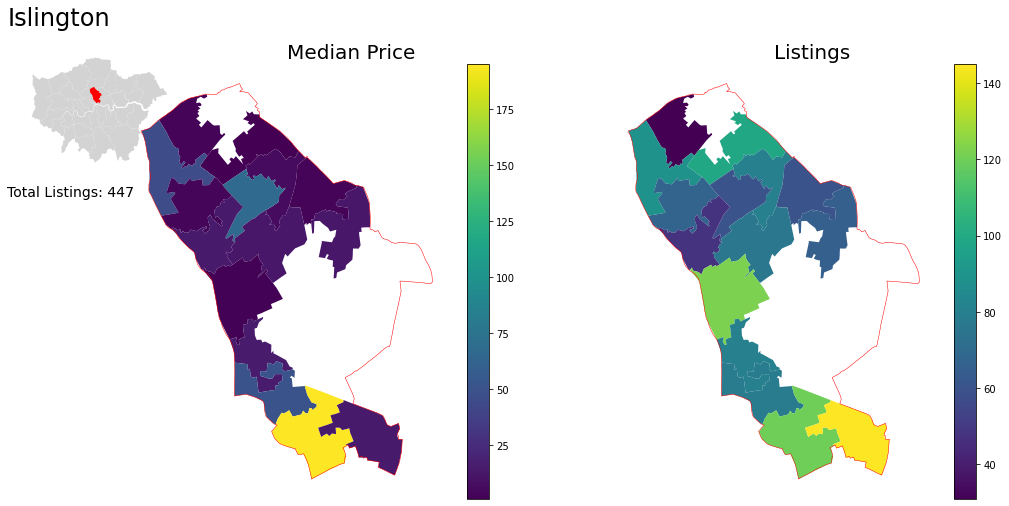

In [95]:
tfont = {'fontname':'DejaVu Sans', 'horizontalalignment':'left'}
f,axes = plt.subplots(1,2,figsize=(16,8))

i_tspot.plot(column='count', ax=axes[0], legend=True, cmap='viridis')
boros[boros.NAME=="Islington"].plot(ax=axes[0],edgecolor='red', facecolor='none',linewidth=0.5)
i_tspot.copy().plot(column='median', ax=axes[1], legend=True, cmap='viridis')
boros[boros.NAME=="Islington"].plot(ax=axes[1],edgecolor='red', facecolor='none',linewidth=0.5)
for ax in axes:
    ax.axis('off')
    
ax2 = f.add_axes([0.005, 0.7, 0.2, 0.2])
boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
boros[boros.NAME=="Islington"].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2)
ax2.axis('off')

f.suptitle("Islington", x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Median Price', size=20, **tfont)
axes[1].set_title('Listings', size=20, **tfont)

plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {i}", size=14, **tfont);

#plt.savefig('west.png')

In [96]:
isl_all = gdf_msoa.groupby(['Borough','MSOA11CD']).agg(
    {'id':['count'],'price':['median']}
).reset_index()
isl_all=isl_all[isl_all.Borough=="Islington"]
isl_all.columns = isl_all.columns.droplevel(0)
cols = isl_all.columns.values
cols[0]  = 'Borough'
cols[1]  = 'MSOA'
isl_all.columns = cols

In [97]:
i_all=gdf_msoa[gdf_msoa['Borough']=="Islington"].id.count()

In [98]:
isl_all=pd.merge(isl_all, msoas[["MSOA11CD",'geometry']],left_on='MSOA',right_on='MSOA11CD', how='right')
isl_all = isl_all.set_geometry('geometry')

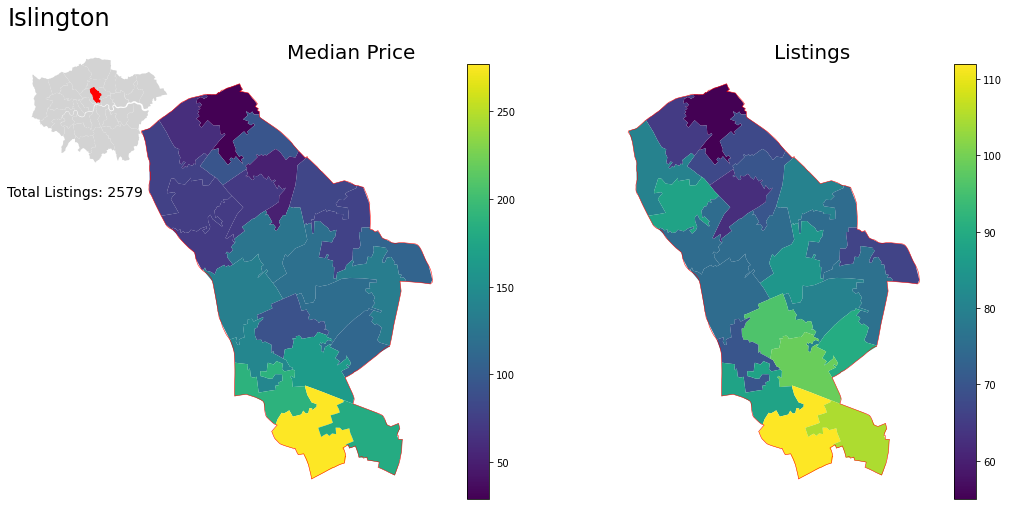

In [99]:
tfont = {'fontname':'DejaVu Sans', 'horizontalalignment':'left'}
f,axes = plt.subplots(1,2,figsize=(16,8))

isl_all.plot(column='count', ax=axes[0], legend=True, cmap='viridis')
boros[boros.NAME=="Islington"].plot(ax=axes[0],edgecolor='red', facecolor='none',linewidth=0.5)
isl_all.copy().plot(column='median', ax=axes[1], legend=True, cmap='viridis')
boros[boros.NAME=="Islington"].plot(ax=axes[1],edgecolor='red', facecolor='none',linewidth=0.5)
for ax in axes:
    ax.axis('off')
    
ax2 = f.add_axes([0.005, 0.7, 0.2, 0.2])
boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
boros[boros.NAME=="Islington"].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2)
ax2.axis('off')

f.suptitle("Islington", x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Median Price', size=20, **tfont)
axes[1].set_title('Listings', size=20, **tfont)

plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {i_all}", size=14, **tfont);

#plt.savefig('west.png')

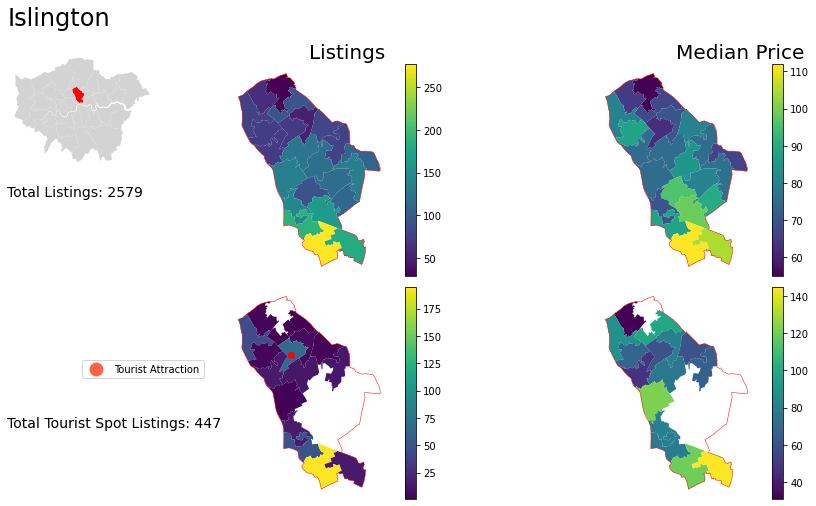

In [100]:
#QUAD GRIDDDDDD
tfont = {'fontname':'DejaVu Sans', 'horizontalalignment':'left'}
f_isl,axes = plt.subplots(2,2,figsize=(13,8))
plt.subplots_adjust(wspace=0.025, hspace=0.05)

isl_all.plot(column='count', ax=axes[0,0], legend=True, cmap='viridis')
boros[boros.NAME=="Islington"].plot(ax=axes[0,0],edgecolor='red', facecolor='none',linewidth=0.5)
isl_all.copy().plot(column='median', ax=axes[0,1], legend=True, cmap='viridis')
boros[boros.NAME=="Islington"].plot(ax=axes[0,1],edgecolor='red', facecolor='none',linewidth=0.5)


i_tspot.plot(column='count', ax=axes[1,0], legend=True, cmap='viridis')
boros[boros.NAME=="Islington"].plot(ax=axes[1,0],edgecolor='red', facecolor='none',linewidth=0.5)
t_isl.plot(ax=axes[1,0],color='red')
i_tspot.copy().plot(column='median', ax=axes[1,1], legend=True, cmap='viridis')
boros[boros.NAME=="Islington"].plot(ax=axes[1,1],edgecolor='red', facecolor='none',linewidth=0.5)





ax2 = f_isl.add_axes([0.005, 0.7, 0.2, 0.2])
boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
boros[boros.NAME=="Islington"].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2)
ax2.axis('off')

f_isl.suptitle("Islington", x=0.025, ha='left', size=24, **tfont)
axes[0,1].set_title('Median Price', size=20, **tfont)
axes[0,0].set_title('Listings', size=20, **tfont)

for ax in axes.flat:
    ax.label_outer()
    ax.axis('off')

plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {i_all}", size=14, **tfont);
plt.figtext(x=0.025, y=0.25, s=f"Total Tourist Spot Listings: {i}", size=14, **tfont);

cus_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markersize=15,label='Tourist Attraction')]
f_isl.legend(handles=cus_legend,loc='center left',bbox_to_anchor=(0.1, 0.1, 0.5, 0.5))
#plt.savefig('Islington.png')

### Plotting against night time econ

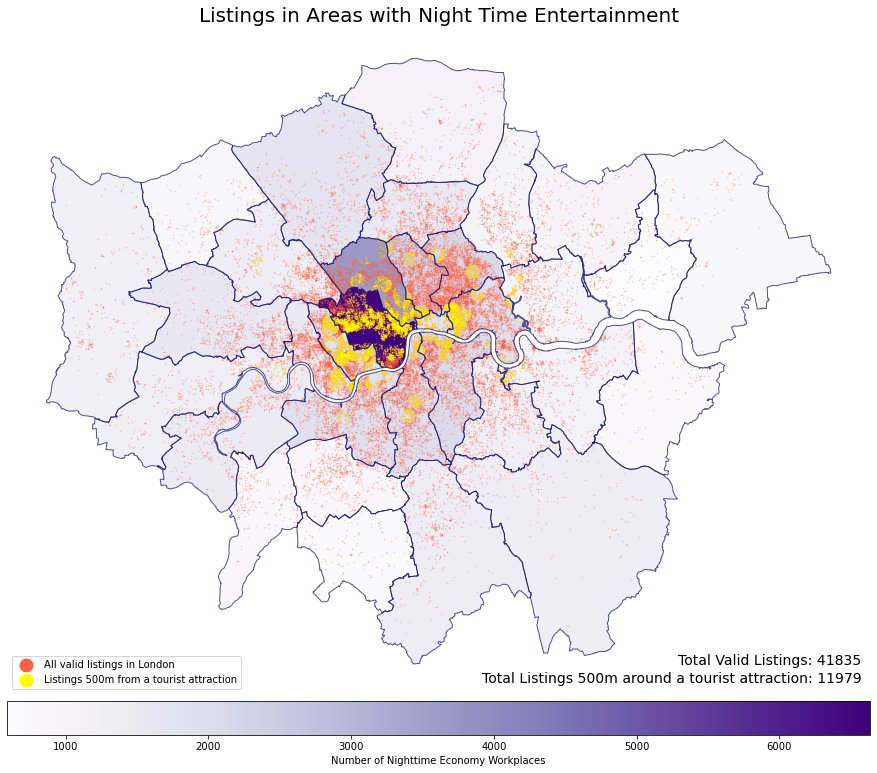

In [101]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig1,ax = plt.subplots(figsize=(16,13))
tfont = {'fontname':'DejaVu Sans'}

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

nte_2017.plot(ax=ax,column="Workplace",legend=True,legend_kwds={'label':'Number of Nighttime Economy Workplaces','orientation':'horizontal'},cmap="Purples",cax=cax)
gpd_df3.plot(ax=ax, alpha=0.3,color='tomato',label= "GG", markersize=0.3)
bnb_500.plot(ax=ax, alpha=0.4,color='yellow', markersize=0.15)
boros.plot(ax=ax, edgecolor='midnightblue', facecolor='none', linewidth=1, alpha=0.75)

ax.set_title("Listings in Areas with Night Time Entertainment", size=20, **tfont)
ax.axis('off')

cus_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markersize=15,label='All valid listings in London'),
                Line2D([0], [0], marker='o',color='w', markerfacecolor='yellow', markersize=15,label='Listings 500m from a tourist attraction')]
ax.legend(handles=cus_legend,loc='lower left')

plt.figtext(x=0.72, y=0.2, s=f"Total Valid Listings: {gpd_df3.shape[0]}", size=14, **tfont);
plt.figtext(x=0.55, y=0.18, s=f"Total Listings 500m around a tourist attraction: {bnb_500.shape[0]}", size=14, **tfont); 
#plt.savefig('nte_map.png')

## NLP Analysis below

In [102]:
bnb_500.sample(3)

,id,name,description,neighborhood_overview,host_id,host_about,latitude,longitude,property_type,room_type,...,bathrooms_text,bedrooms,beds,price,geometry,MSOA11CD,MSOA11NM,Borough,msoa11hclnm,index_right
2536,1906754,Hampstead London...,"Spacious, immacu...",This area has na...,9896581,Greetings! My na...,51.55936,-0.16497,Entire apartment,Entire home/apt,...,1 bath,1.0,1.0,100.0,POINT (527304.39...,E02000167,Camden 002,Camden,Hampstead Town,22
38493,25851392,Room in large fl...,Great room in la...,You can find sho...,194238548,Italian guy livi...,51.49636,-0.08366,Private room in ...,Private room,...,2 shared baths,1.0,1.0,40.0,POINT (533123.98...,E02000812,Southwark 006,Southwark,London Bridge & ...,229
45823,30446185,Double rooms in ...,A spacious doubl...,Wapping is in th...,20422553,I am an experien...,51.50490,-0.06649,Private room in ...,Private room,...,1 shared bath,1.0,1.0,32.0,POINT (534290.69...,E02000890,Tower Hamlets 027,Tower Hamlets,Tower Hill & Wap...,235


In [103]:
bnb_500.description.isna().value_counts()
#nice, dont have to erase rows with NA

False    11979
Name: description, dtype: int64

In [104]:
pd.options.display.max_colwidth=None
#bnb_t[bnb_t.description.str.contains(r'(tourist|attract(?:ions))', regex=True, flags=re.IGNORECASE)].description.sample(3)

In [105]:
#t_word=bnb_500[bnb_500.description.str.contains(r'(tourist|attract(?:ions))', regex=True, flags=re.IGNORECASE)].copy()
t_word=gdf_msoa[gdf_msoa.Borough=='Westminster'].description.copy()
t_word.shape

(4839,)

In [106]:
t_word_df = pd.DataFrame(t_word.drop(columns='geometry'))

In [107]:
#load textual custom module
%load_ext autoreload
%autoreload 2

In [108]:
from textual import *

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [109]:
t_word_df['description_norm'] = ''
t_word_df['description_norm'] = t_word_df.description.apply(normalise_document)

In [110]:
t_word_df['description_norm'].sample(3)

62465    beautiful low ground floor bedroom apartment centrally locate minute walk paddington station close underground station minute walk oxford hyde park minute walk away perfect choice couple small family space apartment bedroom sleep lounge small din table netflix shower room walk shower fully equip modern kitchen dishwasher wash machine microwave kettle toaster coffee maker also small folding bed suitable child teen guest access apartment low ground step private entrance thing note rear patio area private use flat non smoking outside area fine smoke
76378                                                                                                                                                                                                                      luxury apartment set second floor feature designer finish quality wood flooring floor ceiling window bathe property natural light flat feature magnificent living room plenty entertainment din space contemporary high spe

In [111]:
corpus = t_word_df.description_norm.fillna(' ').values

So I heard higher ngrams gives more meaningful word search, lets see

In [112]:
#try getting ngram pairs
data = [x for x in ' '.join(corpus).split() if not re.match(r'[,.\-\(\)!\&0-9\;\:]', x)]

fcounts = dict()

for size in 1, 2, 3, 4:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    # If you only need one, note this: https://stackoverflow.com/questions/15145172/nltk-conditionalfreqdist-to-pandas-dataframe
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})

<FreqDist with 8037 samples and 365020 outcomes>
<FreqDist with 96480 samples and 365019 outcomes>
<FreqDist with 187542 samples and 365018 outcomes>
<FreqDist with 232658 samples and 365017 outcomes>


In [113]:
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))

           Ngram Size 1
apartment          6040
bedroom            5914
space              5718
room               4910
london             4769
flat               4224
kitchen            3918
walk               3910
bed                3881
guest              3564
                   Ngram Size 2
minute  walk               1540
guest   access             1505
living  room               1499
hyde    park               1332
central london             1183
fully   equip              1085
double  bed                1018
bedroom apartment           864
oxford  street              860
double  bedroom             807
                           Ngram Size 3
fully   equip   kitchen             478
king    size    bed                 341
open    plan    kitchen             334
guest   access  guest               256
walk    hyde    park                247
double  sofa    bed                 246
two     bedroom apartment           230
kitchen fully   equip               226
one     bedroom apartmen

guest access guest access???? ngram  size 4 doesnt really generate meaningful things

In [114]:
#vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,4), max_df=0.5, min_df=0.05)
#tcorpus    = vectorizer.fit_transform(corpus)

In [115]:
#doc_df = pd.DataFrame(tcorpus[0].T.todense(), index=vectorizer.get_feature_names(), columns=["Weights"])
#doc_df.sort_values('Weights', ascending=False).head(10)

In [116]:
#tfidf = pd.DataFrame(data=tcorpus.toarray(),
#                        columns=vectorizer.get_feature_names())
#tfidf.head()

In [117]:
#tfidf.sum().sort_values(ascending=False)

In [118]:
#plt.figure(figsize=(12, 12))
#Cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(tfidf.sum())
#plt.imshow(Cloud) 
#plt.axis("off");

### Try doing LDA
Lets see how people had been describing their property

In [119]:
LDA_vectorizer = CountVectorizer(ngram_range=(2,4)) 

In [120]:
LDA_vectorizer.fit(corpus) 
LDA_tcorpus = LDA_vectorizer.transform(corpus)

LDA = LatentDirichletAllocation(n_components=5, random_state=100)
LDA.fit(LDA_tcorpus)

LatentDirichletAllocation(n_components=5, random_state=100)

In [121]:
first_topic = LDA.components_[0]
top_words = first_topic.argsort()[-25:]

for i in top_words:
    print(LDA_vectorizer.get_feature_names()[i])

sofa bed
home away home
brand new
home away
away home
transport link
thing note
notting hill
walk distance
min walk
master bedroom
ground floor
open plan
double bedroom
oxford street
two bedroom
bedroom apartment
double bed
maida vale
central london
hyde park
fully equip
minute walk
living room
guest access


In [122]:
print("Log Likelihood: ", LDA.score(LDA_tcorpus))
print("Perplexity: ", LDA.perplexity(LDA_tcorpus))

Log Likelihood:  -13286311.087390067
Perplexity:  236466.74175191263


In [123]:
for i,topic in enumerate(LDA.components_):
    as_markdown(f'Top 10 words for topic #{i+1}', ', '.join([LDA_vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]]))

#### Top 10 words for topic #1

>sofa bed, home away home, brand new, home away, away home, transport link, thing note, notting hill, walk distance, min walk, master bedroom, ground floor, open plan, double bedroom, oxford street, two bedroom, bedroom apartment, double bed, maida vale, central london, hyde park, fully equip, minute walk, living room, guest access


#### Top 10 words for topic #2

>one bedroom, bedroom bathroom, ground floor, buckingham palace, underground station, equip kitchen, apartment locate, first floor, oxford street, thing note, tube station, open plan, min walk, notting hill, double bedroom, sofa bed, bedroom apartment, walk distance, fully equip, double bed, central london, guest access, hyde park, living room, minute walk


#### Top 10 words for topic #3

>ground floor, two bedroom, linen towel, bedroom bathroom, tube station, fully equip kitchen, equip kitchen, heart london, bedroom flat, min walk, walk distance, bedroom apartment, open plan, sofa bed, double bedroom, notting hill, thing note, oxford street, double bed, fully equip, central london, minute walk, hyde park, living room, guest access


#### Top 10 words for topic #4

>coffee fresh towel bathroom, coffee fresh towel, fresh towel bathroom essential, fresh towel bathroom, coffee fresh, common area, area space, notting hill, fresh towel, guest offer, walk distance, via text, living space, one bedroom, professionally clean, hyde park, double bedroom, open plan, oxford street, bedroom apartment, fully equip, guest access, minute walk, central london, living room


#### Top 10 words for topic #5

>two bedroom, apartment locate, covent garden, bedroom apartment, floor lift, thing note, shower room, bedroom flat, double bedroom, heart london, open plan, notting hill, walk distance, fully equip, duchy house, oxford street, tube station, sofa bed, central london, double bed, min walk, living room, hyde park, guest access, minute walk


Too bad the NLP did not really produce meaningful things, the topics are all similar, it could've been something to do with selecting the descriptions, but this is extra stuff to include in the report anw

# II. Executive Briefing

## Executive Summary 

The COVID-19's effect on UK’s economy is tremendous, the tourism forecast of the UK in 2021 is only 1/3 of the previous year and therefore new ways to boost the economy should be considered, and tourism should consider targetting at other locals travelling into London. Airbnb has been a popular platform for London citizens to lease their spare homes or rooms. It is found different boroughs have different listings targeted at multiple customer segments, and not all areas possess tourist attractions to gain exposure to these supporting services. This report suggests that the 90 night rule in London should be adjusted flexibly, through increasing the limit to 120 nights or exclude room sharing in the count for different boroughs to boost the economy during post COVID recovery. 

 

## Introduction 

In 2019, there are 40.9 million inbound visits to the UK, and in 2020 the number dropped to 9.7 million visitors due to COVID-19, Visit Britain predicts a rise in visits to 17 million in 2021. Despite such an ambiguous move, it is ineligible that tourism is normally a huge aid to creating jobs and supporting businesses by bringing in an average of £127 billion a year to the economy. In 2019, overseas visitors spend an average of £28.4 billion, such is forecasted to be around £9 billion in 2021 (Visit Britain, 2020). With COVID-19 hindering almost all economic activities, it was reported the economy between April and June shrank by 20.4% (British Foreign Policy Group,2020). The tourism sector is still optimistic about recovery and rolling out new schemes and activities to keep travelers interested.  

  

Airbnb is an accommodation platform where individuals lease their spare rooms or holiday houses to those in need, tourists are just one user group. In London, Airbnb listings are very popular, much like the original aim of Airbnb, it mostly caters to tourists who are looking for a more valuable stay. This report aims to evaluate whether during the recovery period from COVID crisis, the 90 night rule should be temporarily adjusted for certain areas in London as not all of them benefit from tourism, therefore the 90 night rule might be too harsh for some. 

  

## Airbnb and Tourism 

### Airbnb's Impact 

London is one of the top destinations for guests on Airbnb, there are around 75,000 listings in 2018. In London, the 90 night rule is introduced under the Deregulation Act of 2015 and effective on the Airbnb platform in January 2017. It limits short-term rentals to 90 or fewer nights per calendar year, hosts will have to request a ‘change of use’ planning permit if they want to rent beyond that limit. The 90 night rule was introduced to prevent loss of permanent residential units (long-term housings) and preserve community culture. 

 

Lee's research points out that any rooms listed on Airbnb is one less potential home for the residential housing market, yet property owners tend to short lease their homes for profit maximization. The 90 night rule exists to limit such use of second homes. 

  

However, from a tourism standpoint, the presence of Airbnb properties might shine light to some zones for urban tourism. Ioannides debated whether the existence of Airbnb is to expand tourism bubbles, since Airbnb is designed to complement hotels, and therefore a crucial force in touristifying areas that lack formal accommodations (ie. hotels). Also, the presence of supporting services like restaurants, bars and hotels will increase the number of listings in an area (Ioannides, 2018). Tourism bubbles are defined as spaces of consumption represented by a mixture of tourism attractions, shopping centers and luxury housing, sharing little to no connection to the rest of the city. Judd (2003) commented some travelers do not like to stay within such bubble but instead seek special and adventurous experiences by doing 'mundane activities'. These group of travelers are called neo-bohemias, and they are more likely to stay in places away from tourist bubbles. 

 

### Case study of regulations in other cities 

One of Airbnb’s largest markets are in Japan with around 62,000 listings in 2018. Japan legalized Airbnb back in June 2018 to protect the hotel industry by amending the Japanese Hotels and Inns Act. Hosts need to get a license to continue operating. Rules include limiting home-sharing to 180 days per calendar year and local authorities were able to add their own requirements. In Kyoto, hosts can only operate from mid-January to mid-March. And in busy districts of Tokyo, hosts can only operate on weekends and holidays. Certain level of flexibility also exists in the form of “Special Zone Private Lodging”, zones that are popular to tourists or next to the airport, these areas are not restricted by the 180 days cap but instead a stay period of 2-9 days. The legalization led to a 80% drop in the number of listings plus a surge in prices (Sugira, 2018). 

 

France is also a popular market on Airbnb with around 60,000 listings in 2018 (News Wire, 2018). In 2017, France introduced the Elan Law that requires Airbnb hosts to register their home and display their license in their Airbnb listings. In addition to that hosts are required to label their homes within the 3 categories: primary, secondary and non-residential space. Hosts leasing their primary residences is literally room-sharing where the hosts and guests live together, and will be restricted by the renting limit of 120 days per calendar year if they rent the whole house out (Airbnb, n.d.).  

 

## Analysis 

Following Ioannides’s observation that features of the built environment supports the emergence of listings, the number of listings in different boroughs with nighttime economy are compared. Assuming tourists visit tourist attractions during daytime, visit and possibly stay in places with night life to maximize their trip value. 

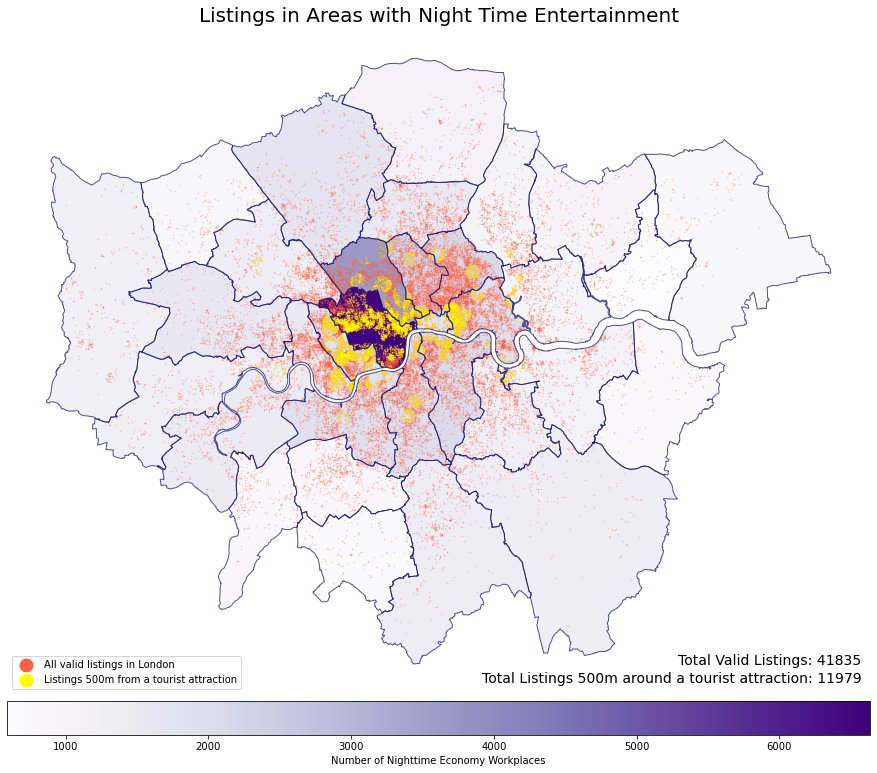

In [124]:
fig1

Listings in general have a dispersing effect in distance from the city center, boroughs in the edges of the Greater London area do not have many listings, and looking at listings that are located 500 meters around tourist spots marked on the Open Street Map (OSM), 11,979 listings take up 28.6% of all valid listings (ie. listings that have description and host information filled out). The map also shows a lot of listings are in Westminster, and Westminster has the most nighttime economy workplaces like restaurants, bars and accommodation like hotels and hostels, and most importantly the proximity to different tourist attractions. However, areas that are less ‘attractive’ in terms of night life and tourist attractions like Islington still got a great number of listings. 

 

According to OSM’s data, there are 111 attractions in Westminster, and only 2 in Islington, yet Islington still have nearly half the number of listings as Westminster (2,579 vs 4,839). The effect of having tourist spots in Westminster and Islington are then compared.  

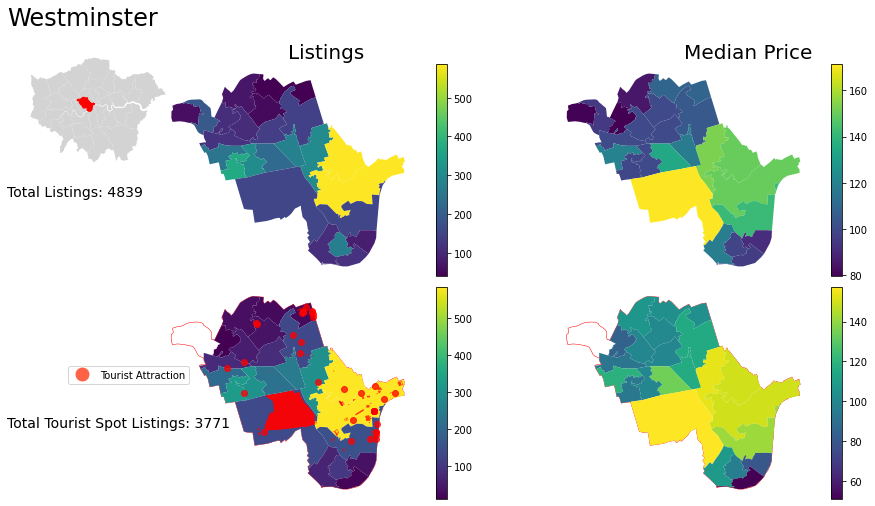

In [125]:
f_west

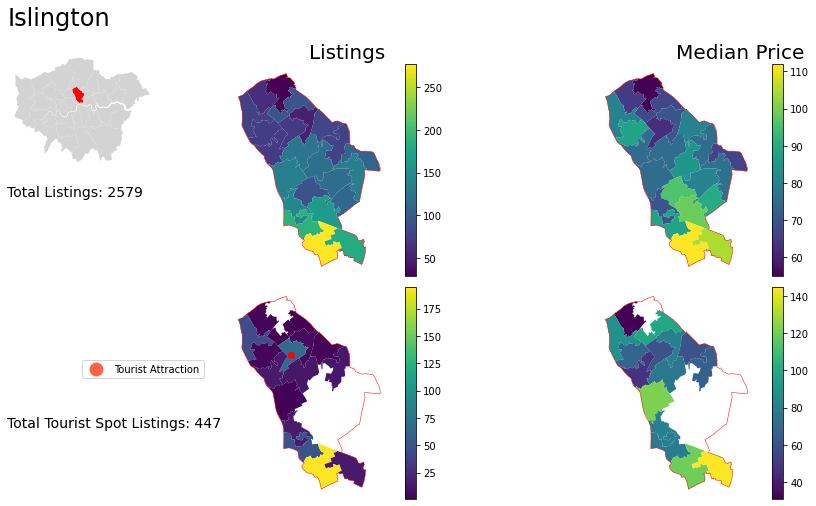

In [126]:
f_isl

The median price of listings in Westminster are generally higher than in Islington, as listings are the most popular along the river for both Westminster and Islington. The entire Westminster area benefitted a lot from having tourist attractions and night life, prices are at a similar level regardless of having tourist spot listings or not. Westminster is the most active borough in the Airbnb London market, this area have different kinds of listings targeted at different spending groups. The most expensive area is where Hyde Park is located, despite having a low number of listings, people who decided to lease there possibly furnished their listings to a luxurious level and aims at the higher spending group of tourists. On the other side, most listings are in the MSOA where shopping hotspots like Oxford Street and restaurant area like Soho are located, but the prices are not the highest, probably due to fierce competition for the average tourists in that area. 

 

In general, areas closest to the river have the most listings, which is common for all boroughs along the river. In Islington, having the Nags Head Market as the only marked tourist attraction did not lift the area’s economy, the MSOA where the market is at do have more listings than its surroundings, but the prices do not differ so much. Placing listings along the river are still the most profitable strategy. 

 

## Recommendations 

With reference to how other countries govern short-term rentals on Airbnb to protect the interests of other industries, flexible measures should also be considered in London, and boroughs should be able to implement the 90 night rule adjustably. Boroughs like Islington and Hackney that do not have much visitor attractions still have a generous number of listings, which kind of matches with the neo-bohemia effect, and neo-bohemias find joy in living the lives of a normal local, coping with local culture and lifestyles instead of visiting tourist areas (Judd, 2003). Yet the 90 night rule is also applicable to the traditional room share listings, which prevents guests from gaining more cultural exchanges with their hosts. Hence room share listings should be excluded from the 90 night count as long as the hosts live together with the guests during the stay.  

 

For popular Boroughs like Westminster and Camden, there are major MSOAs that make up most of the listings in the borough, while the less populated MSOAs (ie. The upper part of Westminster and Camden) do not benefit much from the popular areas. Excluding room sharing mode from the nights count might result in more people flooding into the area causing a ‘loss of residential amenity and housing stock’ (Department for Communities and Local Government, 2015), therefore extending the limit from 90 nights to 120 nights should be considered. 

 

## Conclusion 

London’s 90 night rule might be too harsh on areas that do not benefit economically from the availability of tourist attractions, and not every area is like Westminster who has every attractive feature to become the most popular place on the Airbnb Market and in London. Upcoming hard times like post COVID recovery period, the income source of the tourism industry should not be limited to foreigners but also to other UK citizens visiting London. A study done by Mao's team shows travelors will use Airbnb again based on a good value for the price and unique experience, and therefore a favourable and wise option to consider for the next trip. Boroughs should consider loosening the 90 night rule to some parts of the boroughs to encourage more local spending on Airbnb. 

## References 

 Airbnb. (n.d.). Responsible hosting in the United Kingdom. Retrieved from: 

https://www.airbnb.co.uk/help/article/1379/responsible-hosting-in-the-united-kingdom?_set_bev_on_new_domain=1610037526_Njc1YjhiYmRhZDFk  

Airbnb. (n.d.). Responsible hosting in France. Retrieved from: 

https://www.airbnb.co.uk/help/article/1383/responsible-hosting-in-france?_set_bev_on_new_domain=1610037526_Njc1YjhiYmRhZDFk 

 British Foreign Policy Group. (2020). COVID-19 Timeline. Retrieved from 

 https://bfpg.co.uk/2020/04/covid-19-timeline/ Last Accessed: 8/1/2021 

Department for Communities and Local Government. (2015). Promoting the sharing economy in London Policy on short-term use of residential property in London. Retrieved from :  https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/402411/Promoting_the_sharing_economy_in_London.pdf 

Dimitri Ioannides, Michael Röslmaier & Egbert van der Zee (2019) Airbnb as an instigator of ‘tourism bubble’ expansion in Utrecht's Lombok neighbourhood, _Tourism Geographies_, 21:5, 822-840, DOI: 10.1080/14616688.2018.1454505 

Lee, D. (2016). How Airbnb short-term rentals exacerbate Los Angeles's affordable housing crisis: Analysis and policy recommendations. _Harvard Law & Policy Review_, 10, 229–253.  

Mao, Z. and Lyu, J. (2017).  Why travelers use Airbnb again?: An integrative approach to understanding travelers' repurchase intention. _International Journal of Contemporary Hospitality Management_, vol. 29, (9), pp. 2464-2482, 2017. DOI: http://dx.doi.org.libproxy.ucl.ac.uk/10.1108/IJCHM-08-2016-0439. 

Mayumi, N. (2018). Japan Legalizes Airbnb, and Thousands of Listings Vanish; Reservations are canceled and tempers flare as red tape hinders operators. _Wall Street Journal (Online)_. Retrieved from: https://www.wsj.com/articles/japan-legalizes-airbnb-and-thousands-of-listings-vanish-1528457217 

NEWS WIRES. (2018). Paris official wants Airbnb banned from city centre. Retrieved from: https://www.france24.com/en/20180906-france-paris-official-wants-airbnb-banned-city-centre-ian-brossat 

Russell Cooke. (2018). Change of use short term lets. Retrieved from https://www.russell-cooke.co.uk/changeofuseshorttermlets/ 

Sugiura, E. (2019). Airbnb begins to recover in Japan, a year after crackdown. Retrieved from: https://asia.nikkei.com/Spotlight/The-Big-Story/Airbnb-begins-to-recover-in-Japan-a-year-after-crackdown 

Visit Britain. (2020). VisitBritain inbound tourism forecast for 2021 predicts first signs of slow recovery. Retrieved from: 

https://www.visitbritain.org/visitbritain-inbound-tourism-forecast-2021-predicts-first-signs-slow-recovery 

Zervas, G., Proserpio, D., & Byers, J. W. (2017). The Rise of the Sharing Economy: Estimating the Impact of Airbnb on the Hotel Industry. _Journal of Marketing Research_, 54(5), 687–705. https://doi.org/10.1509/jmr.15.0204 

  


### Datasets 

https://data.london.gov.uk/dataset/london-night-time-economy 

# WORD COUNT
1662 words + 3 figs
= 1662+750
= 2412 words